# Generative modelling in deep learning

Generative modelling in machine learning can aim at achieving different goals.

The first, obvious one is that a generative model can be used to generate more data, to be used afterwards by another algorithm. While a generative model cannot create more information to solve the issue of having too small datasets, it could be used to solve anonymity questions. Typically, sharing a generative model trained on private data could allow the exploitation of the statistical property of this data without sharing the data itself (which can be protected by privacy matters for example).

Another goal is to use generative modelling to better understand the data at hand. This is based on the hypothesis that a model that successfully learned to generate (and generalize) a dataset should have internally learned some efficient and compressed representation of the information contained in the data. In this case, analysing a posteriori the learned representation may give us insights on the data itself.

The notion of a generative model however needs to be more formally specified, in order to work with. What does it mean for the model to generate data that "looks like" the original dataset? A mathematical formulation of that is necessary, in order to define a training objective that can be used efficiently. Having some expert rate the quality of all generated datapoints one by one is definitely not an option.

Thus, modelling our data and models as probability distributions comes to the rescue. If we consider our data as coming from some underlying probability distribution, that we will name $p_D$, our goal is thus to train our model to represent another probability distribution, which we will name $p_\theta$, that should be some good approximation of $p_D$. Given that we only know $p_D$ through some set of realisations from it (the dataset), we can never hope to learn it exactly.

**Q1: Can you name some metrics that can be used to compare two given distributions $p_D$ and $p_\theta$?**

The most famous metric to compare two given distributions $p_D$ and $p_\theta$ is the **Kullback–Leibler divergence**. Which is computed as follows:

$$
D_{KL}(p_D, p_\theta) = \sum_{x \in X} p_D(x) log\left (\frac{p_D(x)}{p_\theta(x)} \right )
$$

Note that this metric shows the 'divergence' between the distributions, so the lower it is, the more similar the distributions are.

Another metric to compare the similarity of two distributions is the **Bhattacharyya distance**. It is computed as follows:

$$
D_B(p_D, p_\theta) = -ln \left (\sum_{x \in X} \sqrt{p_D(x) p_\theta(x)} \right )
$$

For this one too, it is a distance metric.


Most comparison methods can be separated into two kinds: those that compare the density of the distributions ($p_\theta(x)$ vs $p_D(x)$), and those that compare the values sampled from them. These two kinds of approaches have different behavior and trade-offs.

**Q2: Given we want to use them as an optimisation objective, what are the caveats to keep in mind about these two kinds?**

Since we want to use these metrics as optimisation objective, we should be careful about their derivability. To make the optimisation simpler, we will want the metric to be at least continuous and derivable once.

In this work, we will focus on two of the most widely used generative models based on deep neural networks: Generative Adversarial Networks (GANs) and Variational AutoEncoders (VAEs), in order to compare them and understand their strengths and weaknesses.

### Generative Adversarial Networks

GANs structure is based on modelling the distribution $p_\theta$ as a learned deterministic function applied to a standard noise. Sampling from it is thus done as follows: first, some noise is sampled from a standard N-dimensional Gaussian distribution: $\epsilon \sim \mathcal{N}(0;I)$, and then the output is computed as a deterministic function $x = f_\theta(\epsilon)$. The function $f_\theta$ is implemented as a neural network, $\theta$ representing its learned parameters.

**Q3: What is, a priori, the impact of the choice of N, the dimension of the input noise $\epsilon$?**

A priori, the choice of N determines how much information is actually carried by the actual distribution, it represents the multivariate aspect of the distribution we want to estimate. In reality we expect the distribution to lie in a small dimension noise, so we should have N much lower than the dimension of the input.

By construction, this generator structure only allows sampling the distribution $p_\theta$, and does not allow the computation of the density $p_\theta(x)$ (at least not without strong assumptions on $f_\theta$). Such a model thus needs a comparison method based on samples to be trained.

The smart idea of GANs is to instead use another neural network to model the objective. Another neural network is introduced: a classifier (that we call the discriminator) which is trained to distinguish examples from the dataset from examples generated by $p_\theta$. The reasoning is as follows:

The discriminator $D$ is trained using a classic classifier loss between the two classes defined as the samples generated by either $p_D$ or $p_\theta$. This way $D(x)$ can be interpreted as the probability that $x$ came from the real dataset:

$$ \mathcal{L}_D = \mathbb{E}_{p_D} \left[ -\log D(x) \right] + \mathbb{E}_{p_\theta} \left[ -\log \left(1-D(x)\right) \right] $$

From that, it can be shown that for the generator fixed, the optimal discriminator is given by $D(x) = \frac{p_D(x)}{p_\theta(x) + p_D(x)}$, and when reached its loss takes a specific value:

$$ \mathcal{L}_D = 2 \left( \log 2 - JSD(p_\theta \| p_D) \right) $$
, where JSD is the JS divergence used to measure the similarity of two distributions. 
$$JSD(p_\theta \| p_D) = \frac{1}{2} \mathbb{E}_{p_D} \left[ log(\frac{2p_D}{p_D+p_\theta}) \right] + \frac{1}{2} \mathbb{E}_{p_\theta} \left[ log(\frac{2p_\theta}{p_D+p_\theta}) \right]$$
So, training the generator network to *maximize* the same loss would, assuming the discriminator is always trained to optimality, minimize the Jensen-Shannon Divergence between $p_\theta$ and $p_D$, and thus bring $p_\theta$ closer to $p_D$.

**Q4: Can you anticipate a caveat of using the JSD as a training objective for the generator?**

The problem we could encounter when using the JS Divergence is that if there is an area where the two distributions are not overlapping, then in this area, the divergence is constant. Thus, it becomes impossible to get closer to the actual distribution with a gradient descent optimizer.

Having the generator trained to maximize $\mathcal{L}_D$ is equivalent to setting its training loss to $ \mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x)) $.

**Q5: This loss only gives feedback to the generator on samples it generated, what problem may this cause?**

Since this loss only gives feedback to the generator on samples it generated, we might miss the best estimation of the distribution if we never generate samples close to it. For example, we might get stuck into a local optimum which never leads us to generating better samples.

We will now work on implementing a GAN on a simple toy problem, to get a feeling of its behavior and test our theoretical insights. For this we will use the `pytorch` library.

While a real problem would be generating images for example (each datapoint $x$ would then be a different image), this is a kind of task that easily requires intensive CPU/GPU power, and image datasets are difficult to visualize from a geometric point of view (even small images contains hundreds of pixels, and nobody can visualize points in a 100-dimensional space). So instead we will focus on points in the plane: each datapoint $x$ will actually be a couple of numbers $(x1, x2)$, and our target dataset will be a 2D two-moons shape with some noise.

In [1]:
import torch
import math
from sklearn import datasets
import numpy as np

# Our dataset is mathematically defined, we can generate batches on the fly and enjoy
# an infinite-size dataset
def generate_batch(batchlen):
    """This function generates a batch of length 'batchlen' from the dataset
    """
    data = datasets.make_moons(n_samples=batchlen, noise=0.05)[0].astype(np.float32)
    return torch.from_numpy(data)

Let's plot a large batch, to see what the dataset looks like.

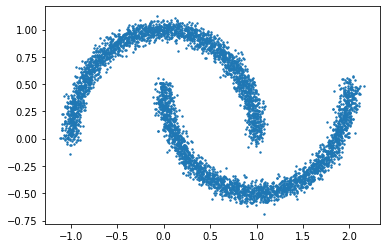

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

batch = generate_batch(5000)

plt.scatter(batch[:,0], batch[:,1], s=2.0)
plt.show()

We now need to define our two neural networks, the generator and the discriminator. The generator will take as input a value $z$ sampled from a Gaussian prior, and output a value $x$ (thus a couple $(x_1,x_2)$). The discriminator takes as input a value $x$, and is a binary classifier.

In [3]:
import torch.nn as nn
import torch.nn.functional as F

# Choose a value for the prior dimension
PRIOR_N = 10

# Define the generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(PRIOR_N, 2)
        
    def __call__(self, z):
        return self.fc1(z)
    
    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, PRIOR_N), 1.0)
        return self.__call__(z)
    

# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 1)
    
    def __call__(self, x):
        return torch.sigmoid(self.fc1(x))

With these classes in shape, now is only needed the training loop. To stick with the mathematical GAN framework, we should train the discriminator until convergence between each training step of the generator. This is not practical for two reasons: first it takes a lot of time, and second if the discriminator is too good, it will generate vanishing gradients to the generator (as seen in **Q4**).

We will thus train the discriminator a fixed number of times between each training iteration of the generator.

step 0: discriminator: 1.363e+00, generator: -7.885e-01


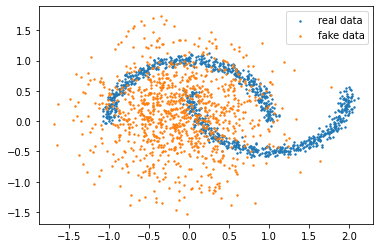

step 1000: discriminator: 1.394e+00, generator: -6.912e-01


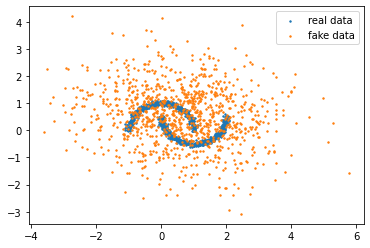

step 2000: discriminator: 1.387e+00, generator: -6.923e-01


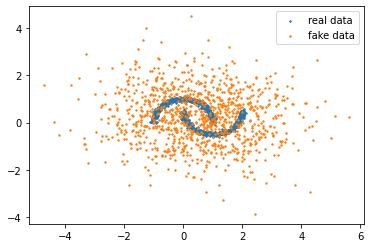

step 3000: discriminator: 1.386e+00, generator: -6.924e-01


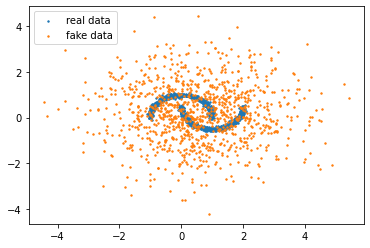

step 4000: discriminator: 1.386e+00, generator: -6.923e-01


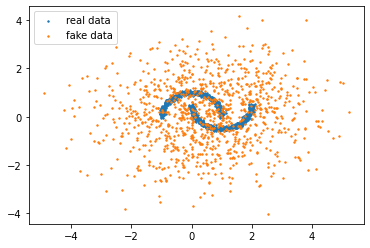

step 5000: discriminator: 1.387e+00, generator: -6.939e-01


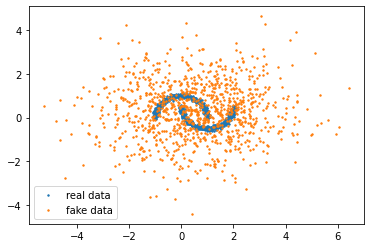

step 6000: discriminator: 1.387e+00, generator: -6.931e-01


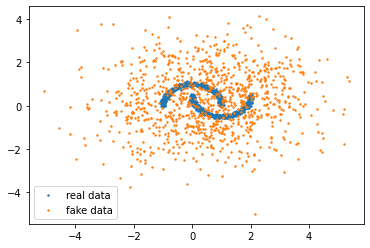

step 7000: discriminator: 1.387e+00, generator: -6.929e-01


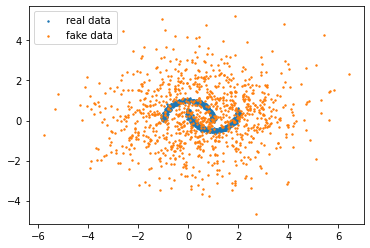

step 8000: discriminator: 1.386e+00, generator: -6.935e-01


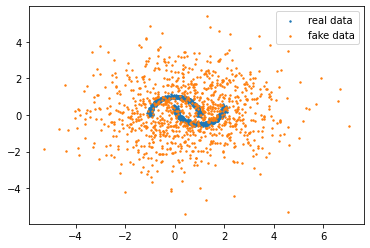

step 9000: discriminator: 1.386e+00, generator: -6.931e-01


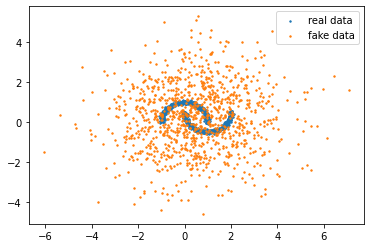

step 10000: discriminator: 1.386e+00, generator: -6.945e-01


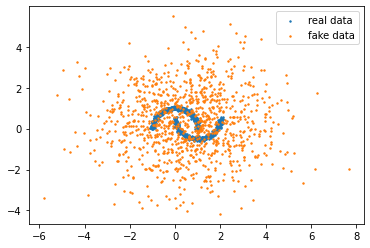

step 11000: discriminator: 1.386e+00, generator: -6.932e-01


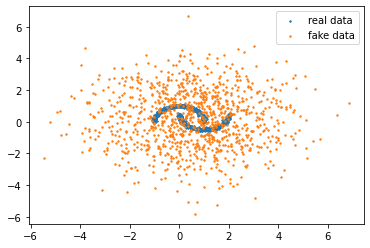

step 12000: discriminator: 1.387e+00, generator: -6.931e-01


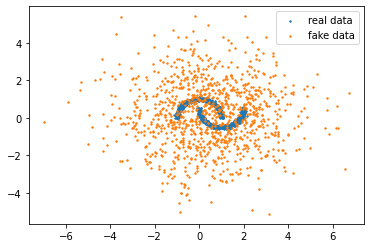

step 13000: discriminator: 1.387e+00, generator: -6.928e-01


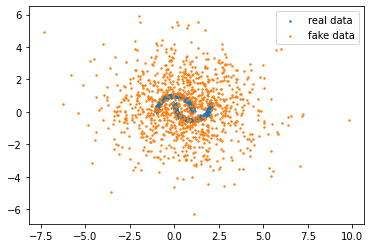

step 14000: discriminator: 1.386e+00, generator: -6.931e-01


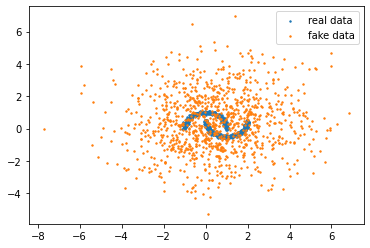

step 15000: discriminator: 1.387e+00, generator: -6.927e-01


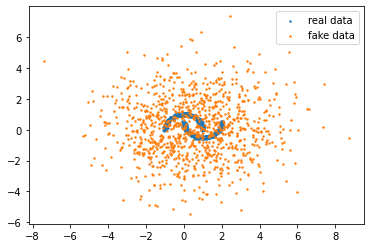

step 16000: discriminator: 1.387e+00, generator: -6.933e-01


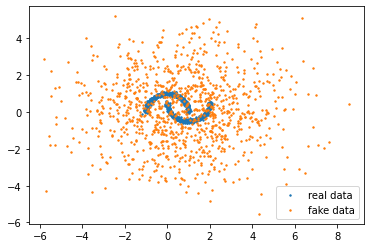

step 17000: discriminator: 1.386e+00, generator: -6.930e-01


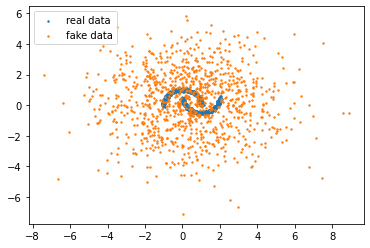

step 18000: discriminator: 1.387e+00, generator: -6.936e-01


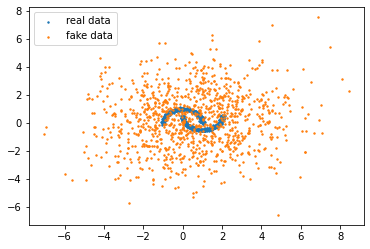

step 19000: discriminator: 1.386e+00, generator: -6.926e-01


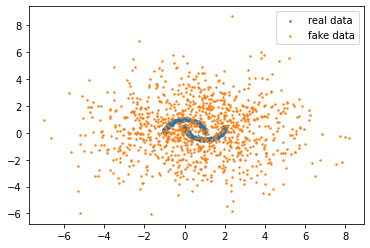

step 20000: discriminator: 1.386e+00, generator: -6.942e-01


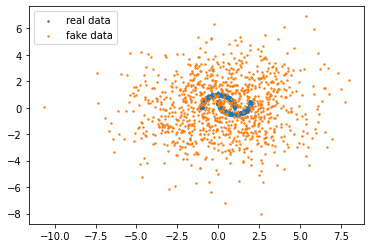

In [ ]:
# Number of times to train the discriminator between two generator steps
TRAIN_RATIO = 1
# Total number of training iterations for the generator
N_ITER = 20001
# Batch size to use
BATCHLEN = 128

generator = Generator()
optim_gen = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5,0.9))
discriminator = Discriminator()
optim_disc = torch.optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5,0.9))

gen_losses = []
disc_losses = []
for i in range(N_ITER):
    # train the discriminator
    for _ in range(TRAIN_RATIO):
        discriminator.zero_grad()
        real_batch = generate_batch(BATCHLEN)
        fake_batch = generator.generate(BATCHLEN)
        #
        # == COMPUTE THE DISCRIMINATOR LOSS HERE ==
        #
        disc_real = discriminator(real_batch)
        disc_fake = discriminator(fake_batch)
        disc_loss = - torch.mean(torch.log(disc_real) + torch.log (1 - disc_fake))
        # print(disc_loss.item())
        disc_loss.backward()
        optim_disc.step()
    # train the generator
    generator.zero_grad()
    fake_batch = generator.generate(BATCHLEN)
    #
    # == COMPUTE THE GENERATOR LOSS HERE
    #
    disc_fake = discriminator(fake_batch)
    gen_loss = torch.mean(torch.log(1-disc_fake))
    gen_loss.backward()
    optim_gen.step()
    
    gen_losses.append(float(gen_loss))
    disc_losses.append(float(disc_loss))

    if i%1000 == 0:
        print('step {}: discriminator: {:.3e}, generator: {:.3e}'.format(i, float(disc_loss), float(gen_loss)))
        # plot the result
        real_batch = generate_batch(1024)
        fake_batch = generator.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()

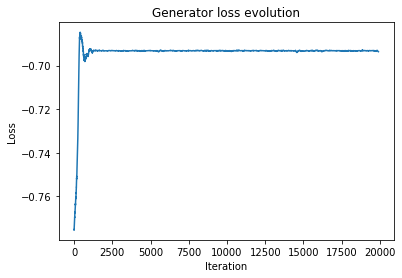

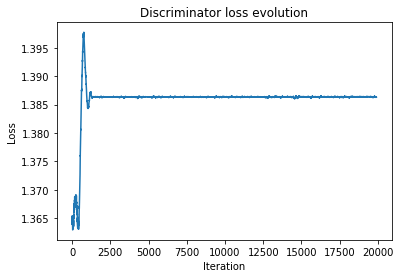

In [ ]:

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

n=100

plt.figure()
plt.plot(np.arange(len(gen_losses)-n+1), moving_average(gen_losses, n))
plt.title("Generator loss evolution")
plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.figure()
plt.plot(np.arange(len(disc_losses)-n+1), moving_average(disc_losses, n))
plt.title("Discriminator loss evolution")
plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.show()


Complete the previous code and train your model.

Depending on your choice of parameters, the training may not go well at all, with the generator completely collapsing quickly at the beginning of the training. It has been observed by the litterature that the generator's loss $\mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x))$ is often to blame.

**Q6: Why could we anticipate that this loss could cause this?**

When the discriminator is trained too well, then the generator's loss $\mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x))$ becomes constant. Thus, the gradients of the generator's loss vanish and the generator cannot be trained anymore.

This issue is solved by replacing the generator loss by an alternative loss: $\mathcal{L}_G = \mathbb{E}_{p_\theta} [ -\log D(x) ]$ to avoid gradient vanishing.

**Q7: Inspect the impact of these different factors:**

- depth / width of the generator network
- depth / width of the discriminator network
- impact of `TRAIN_RATIO`

In [ ]:
from itertools import zip_longest

# Choose a value for the prior dimension
PRIOR_N = 2

# Define the generator
class Generator(nn.Module):
    def __init__(self, hidden_layers=None):
        super().__init__()
        
        self.hidden_layers = hidden_layers or []
        layers = []
        if len(self.hidden_layers) == 0:
            layers += [nn.Linear(PRIOR_N, 2)]
        else:
            layers += [
                       nn.Linear(PRIOR_N, self.hidden_layers[0]), 
                       nn.ReLU()
                       ]
            for i in range(len(self.hidden_layers)-1):
                layers += [
                           nn.Linear(self.hidden_layers[i], 
                                     self.hidden_layers[i+1]),    
                           nn.ReLU()
                           ]
            layers += [nn.Linear(self.hidden_layers[-1], 2)]
        self.model = nn.Sequential(*layers)
        
    def __call__(self, z):
        return self.model(z)
    
    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, PRIOR_N), 1.0)
        return self.__call__(z)
    

# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self, hidden_layers=None):
        super().__init__()
        
        self.hidden_layers = hidden_layers or []
        layers = []
        if len(self.hidden_layers) == 0:
            layers += [nn.Linear(2, 1), nn.Sigmoid()]
        else:
            layers += [
                       nn.Linear(2, self.hidden_layers[0]), 
                       nn.ReLU(), 
                       nn.Dropout(0.3)
                       ]
            for i in range(len(self.hidden_layers)-1):
                layers += [
                           nn.Linear(self.hidden_layers[i], 
                                     self.hidden_layers[i+1]),    
                           nn.ReLU(), 
                           nn.Dropout(0.3)
                           ]
            layers += [nn.Linear(self.hidden_layers[-1], 1), nn.Sigmoid()]
        self.model = nn.Sequential(*layers)
    
    def __call__(self, x):
        return self.model(x)


In [ ]:

def train_gan(generator, discriminator, train_ratio, n_iter, batchlen):
    optim_gen = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5,0.9))
    optim_disc = torch.optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5,0.9))
    gen_losses = []
    disc_losses = []
    for i in range(n_iter):
        # train the discriminator
        for _ in range(train_ratio):
            discriminator.zero_grad()
            real_batch = generate_batch(batchlen)
            fake_batch = generator.generate(batchlen)
            #
            # == COMPUTE THE DISCRIMINATOR LOSS HERE ==
            #
            disc_real = discriminator(real_batch)
            disc_fake = discriminator(fake_batch)
            disc_loss = - torch.mean(torch.log(disc_real) + torch.log (1 - disc_fake))
            # print(_, disc_loss.item())
            disc_loss.backward()
            optim_disc.step()
        # train the generator
        generator.zero_grad()
        fake_batch = generator.generate(batchlen)
        #
        # == COMPUTE THE GENERATOR LOSS HERE
        #
        disc_fake = discriminator(fake_batch)
        # gen_loss = torch.mean(torch.log(1-disc_fake))
        gen_loss = torch.mean(-torch.log(disc_fake))
        gen_loss.backward()
        optim_gen.step()
        
        gen_losses.append(float(gen_loss))
        disc_losses.append(float(disc_loss))

        if i%1000 == 0:
            print('Step {}: discriminator: {:.3e}, generator: {:.3e}'.format(i, float(disc_loss), float(gen_loss)))
        if np.isnan(float(gen_loss)):
            print("Training stopped at step", i)
            break
    return gen_losses, disc_losses 


In [ ]:

def plot_gan(generator, title=None):
    plt.figure()
    real_batch = generate_batch(1024)
    fake_batch = generator.generate(1024).detach()
    plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
    plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
    if title is not None:
        plt.title(title)
    plt.legend()
    plt.show()


Step 0: discriminator: 1.387e+00, generator: 7.480e-01
Step 1000: discriminator: 1.334e+00, generator: 7.769e-01
Step 2000: discriminator: 1.325e+00, generator: 8.084e-01
Step 3000: discriminator: 1.344e+00, generator: 7.405e-01
Step 4000: discriminator: 1.333e+00, generator: 7.714e-01
Step 5000: discriminator: 1.387e+00, generator: 7.077e-01


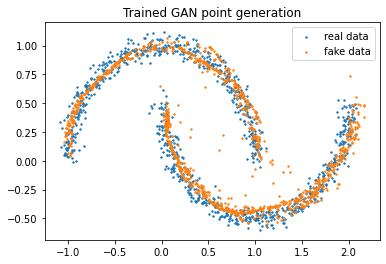

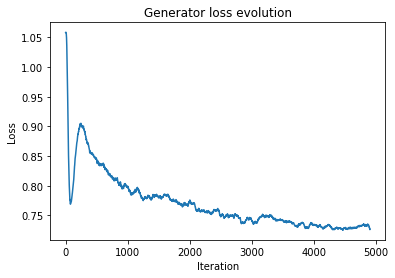

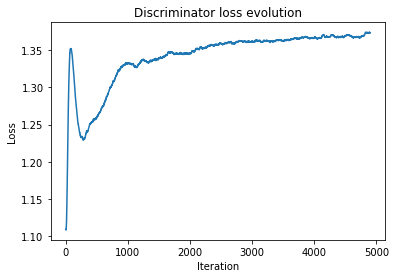

In [ ]:
# Number of times to train the discriminator between two generator steps
TRAIN_RATIO = 1
# Total number of training iterations for the generator
N_ITER = 5001
# Batch size to use
BATCHLEN = 128

generator = Generator(hidden_layers=[16, 32])
discriminator = Discriminator(hidden_layers=[256, 128, 64])
gen_losses, disc_losses = train_gan(generator, discriminator, TRAIN_RATIO, N_ITER, BATCHLEN)
plot_gan(generator, title="Trained GAN point generation")

n=100

plt.figure()
plt.plot(np.arange(len(gen_losses)-n+1), moving_average(gen_losses, n))
plt.title("Generator loss evolution")
plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.figure()
plt.plot(np.arange(len(disc_losses)-n+1), moving_average(disc_losses, n))
plt.title("Discriminator loss evolution")
plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.show()


#### Impact of depth / width of the generator network

Training GAN with generator 'No hidden layers'...
Step 0: discriminator: 1.389e+00, generator: 6.830e-01
Training stopped at step 772


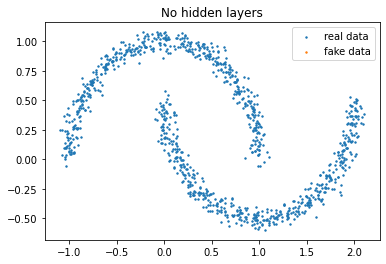

Training GAN with generator 'One hidden layer (16 nodes)'...
Step 0: discriminator: 1.400e+00, generator: 7.289e-01
Step 1000: discriminator: 1.074e+00, generator: 1.206e+00
Step 2000: discriminator: 9.850e-01, generator: 1.230e+00
Training stopped at step 2695


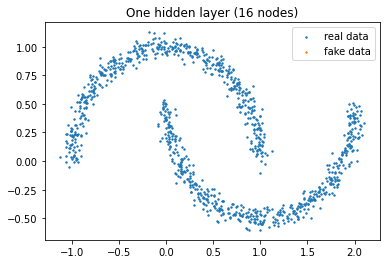

Training GAN with generator 'One hidden layer (32 nodes)'...
Step 0: discriminator: 1.400e+00, generator: 6.961e-01
Step 1000: discriminator: 1.092e+00, generator: 1.085e+00
Step 2000: discriminator: 1.272e+00, generator: 1.044e+00
Step 3000: discriminator: 1.215e+00, generator: 8.951e-01
Step 4000: discriminator: 1.306e+00, generator: 8.822e-01
Step 5000: discriminator: 1.304e+00, generator: 9.557e-01


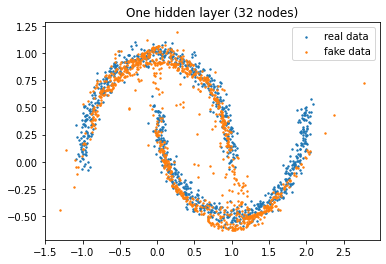

Training GAN with generator 'One hidden layer (64 nodes)'...
Step 0: discriminator: 1.389e+00, generator: 7.066e-01
Step 1000: discriminator: 1.346e+00, generator: 7.568e-01
Step 2000: discriminator: 1.334e+00, generator: 7.724e-01
Step 3000: discriminator: 1.355e+00, generator: 9.205e-01
Step 4000: discriminator: 1.302e+00, generator: 8.254e-01
Step 5000: discriminator: 1.360e+00, generator: 7.488e-01


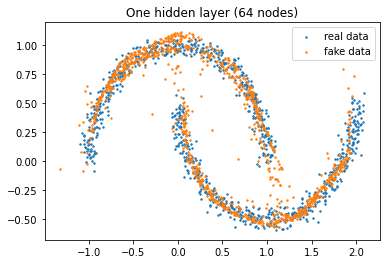

Training GAN with generator 'Two hidden layers (16x16 nodes)'...
Step 0: discriminator: 1.396e+00, generator: 6.766e-01
Step 1000: discriminator: 1.218e+00, generator: 1.147e+00
Step 2000: discriminator: 1.311e+00, generator: 8.560e-01
Step 3000: discriminator: 1.323e+00, generator: 8.460e-01
Step 4000: discriminator: 1.320e+00, generator: 7.303e-01
Step 5000: discriminator: 1.332e+00, generator: 7.743e-01


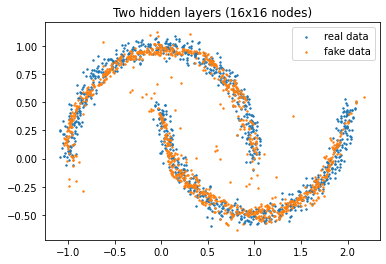

Training GAN with generator 'Three hidden layers (16x16x16 nodes)'...
Step 0: discriminator: 1.396e+00, generator: 7.073e-01
Step 1000: discriminator: 1.320e+00, generator: 7.924e-01
Step 2000: discriminator: 1.328e+00, generator: 7.418e-01
Step 3000: discriminator: 1.366e+00, generator: 6.919e-01
Step 4000: discriminator: 1.383e+00, generator: 7.183e-01
Step 5000: discriminator: 1.378e+00, generator: 6.998e-01


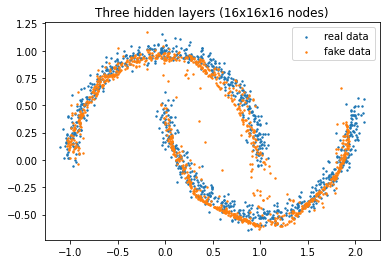

In [ ]:
# Number of times to train the discriminator between two generator steps
TRAIN_RATIO = 1
# Total number of training iterations for the generator
N_ITER = 5001
# Batch size to use
BATCHLEN = 128

# generator = Generator(hidden_layers=[16, 32])
# discriminator = Discriminator(hidden_layers=[256, 128, 64])

generators = [
    ([], "No hidden layers"), 
    ([16], "One hidden layer (16 nodes)"),
    ([32], "One hidden layer (32 nodes)"),
    ([64], "One hidden layer (64 nodes)"),
    ([16, 16], "Two hidden layers (16x16 nodes)"),
    ([16, 16, 16], "Three hidden layers (16x16x16 nodes)"),
]
for hidden_layers, title in generators:
    print(f"Training GAN with generator '{title}'...")
    generator = Generator(hidden_layers=hidden_layers)
    discriminator = Discriminator(hidden_layers=[256, 128, 64])
    gen_losses, disc_losses = train_gan(generator, discriminator, TRAIN_RATIO, N_ITER, BATCHLEN)
    plot_gan(generator, title=title)


**Interpretation:**

We can see on the previous graphs that the generator is greatly impacted by the width and less impacted by the depth (but it needs at least one hidden layer to perform correctly with this discriminator). We will choose a depth for 2 for the rest of the exercise to preserve some stability in the performances.

#### Impact of depth / width of the discriminator network

Training GAN with discriminator 'No hidden layers'...
Step 0: discriminator: 1.457e+00, generator: 4.523e-01
Step 1000: discriminator: 1.909e+00, generator: 3.295e-01
Step 2000: discriminator: 1.394e+00, generator: 6.899e-01
Step 3000: discriminator: 1.386e+00, generator: 6.934e-01
Step 4000: discriminator: 1.388e+00, generator: 6.931e-01
Step 5000: discriminator: 1.385e+00, generator: 6.941e-01


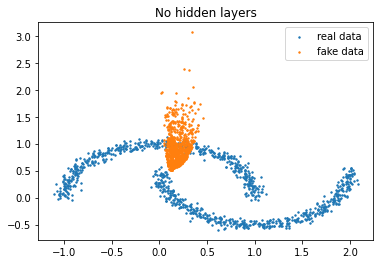

Training GAN with discriminator 'One hidden layer (64 nodes)'...
Step 0: discriminator: 1.435e+00, generator: 5.966e-01
Step 1000: discriminator: 1.162e+00, generator: 1.139e+00
Step 2000: discriminator: 2.021e+00, generator: 6.719e-01
Step 3000: discriminator: 1.145e+00, generator: 8.606e-01
Step 4000: discriminator: 1.788e+00, generator: 8.678e-01
Step 5000: discriminator: 2.054e+00, generator: 3.543e-01


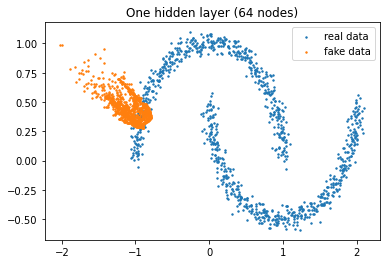

Training GAN with discriminator 'One hidden layer (128 nodes)'...
Step 0: discriminator: 1.328e+00, generator: 7.466e-01
Step 1000: discriminator: 7.614e-01, generator: 1.574e+00
Step 2000: discriminator: 1.849e+00, generator: 1.269e+00
Step 3000: discriminator: 1.319e+00, generator: 8.348e-01
Step 4000: discriminator: 1.802e+00, generator: 1.403e+00
Step 5000: discriminator: 3.152e+00, generator: 4.265e-01


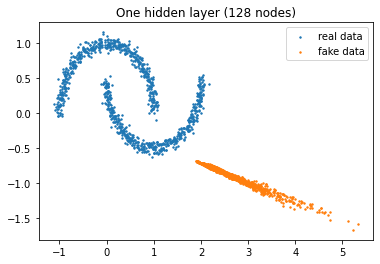

Training GAN with discriminator 'One hidden layer (256 nodes)'...
Step 0: discriminator: 1.344e+00, generator: 5.835e-01
Step 1000: discriminator: 9.615e-01, generator: 1.294e+00
Step 2000: discriminator: 1.932e+00, generator: 9.611e-01
Step 3000: discriminator: 1.664e+00, generator: 8.770e-01
Step 4000: discriminator: 1.228e+00, generator: 8.514e-01
Step 5000: discriminator: 1.340e+00, generator: 6.256e-01


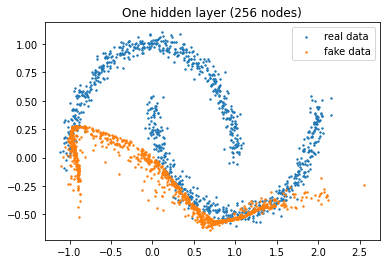

Training GAN with discriminator 'Two hidden layers (128x128 nodes)'...
Step 0: discriminator: 1.418e+00, generator: 6.895e-01
Step 1000: discriminator: 1.377e+00, generator: 6.910e-01
Step 2000: discriminator: 1.389e+00, generator: 6.994e-01
Step 3000: discriminator: 1.385e+00, generator: 6.921e-01
Step 4000: discriminator: 1.389e+00, generator: 7.051e-01
Step 5000: discriminator: 1.383e+00, generator: 6.977e-01


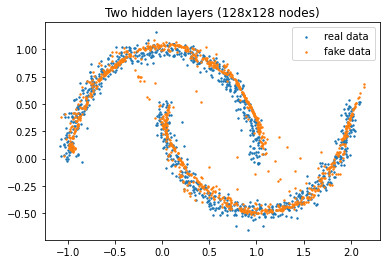

Training GAN with discriminator 'Three hidden layers (128x128x128 nodes)'...
Step 0: discriminator: 1.369e+00, generator: 7.347e-01
Step 1000: discriminator: 1.351e+00, generator: 7.074e-01
Step 2000: discriminator: 1.320e+00, generator: 7.468e-01
Step 3000: discriminator: 1.374e+00, generator: 7.377e-01
Step 4000: discriminator: 1.377e+00, generator: 7.430e-01
Step 5000: discriminator: 1.355e+00, generator: 7.668e-01


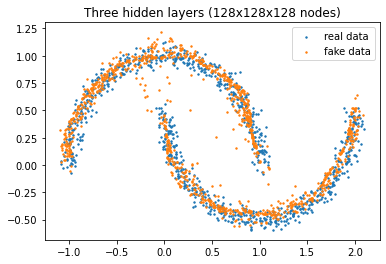

In [ ]:
# Number of times to train the discriminator between two generator steps
TRAIN_RATIO = 1
# Total number of training iterations for the generator
N_ITER = 5001
# Batch size to use
BATCHLEN = 128

# generator = Generator(hidden_layers=[16, 32])
# discriminator = Discriminator(hidden_layers=[256, 128, 64])

discriminators = [
    ([], "No hidden layers"), 
    ([64], "One hidden layer (64 nodes)"),
    ([128], "One hidden layer (128 nodes)"),
    ([256], "One hidden layer (256 nodes)"),
    ([128, 128], "Two hidden layers (128x128 nodes)"),
    ([128, 128, 128], "Three hidden layers (128x128x128 nodes)"),
]
for hidden_layers, title in discriminators:
    print(f"Training GAN with discriminator '{title}'...")
    generator = Generator(hidden_layers=[16, 32])
    discriminator = Discriminator(hidden_layers=hidden_layers)
    gen_losses, disc_losses = train_gan(generator, discriminator, TRAIN_RATIO, N_ITER, BATCHLEN)
    plot_gan(generator, title=title)


**Interpretation:**

We can see on the previous graphs that the discriminator is also greatly impacted by the width and less impacted by the depth. In particular with the wrong width setting we can see that the algorihtm does not fit the input distribution at all. Moreover, with more depth, the discriminator performs more consistently so we will choose a depth of 3 in general.

#### Impact of TRAIN_RATIO

Training GAN TRAIN_RATIO=1...
Step 0: discriminator: 1.388e+00, generator: 6.721e-01
Step 1000: discriminator: 1.339e+00, generator: 7.796e-01
Step 2000: discriminator: 1.358e+00, generator: 7.767e-01
Step 3000: discriminator: 1.371e+00, generator: 7.903e-01
Step 4000: discriminator: 1.394e+00, generator: 7.443e-01
Step 5000: discriminator: 1.353e+00, generator: 7.128e-01


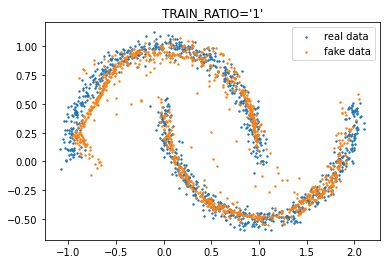

Training GAN TRAIN_RATIO=2...
Step 0: discriminator: 1.368e+00, generator: 6.787e-01
Step 1000: discriminator: 1.329e+00, generator: 7.997e-01
Step 2000: discriminator: 1.364e+00, generator: 7.782e-01
Step 3000: discriminator: 1.385e+00, generator: 7.258e-01
Step 4000: discriminator: 1.379e+00, generator: 6.974e-01
Step 5000: discriminator: 1.392e+00, generator: 7.533e-01


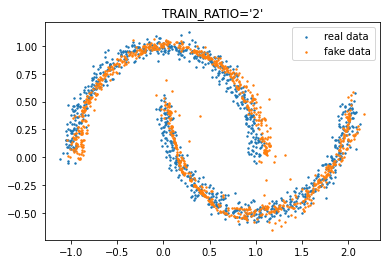

Training GAN TRAIN_RATIO=5...
Step 0: discriminator: 1.330e+00, generator: 6.977e-01
Training stopped at step 79


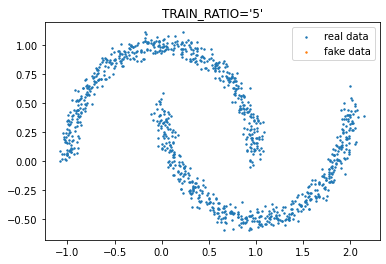

Training GAN TRAIN_RATIO=10...
Step 0: discriminator: 1.123e+00, generator: 8.474e-01
Training stopped at step 220


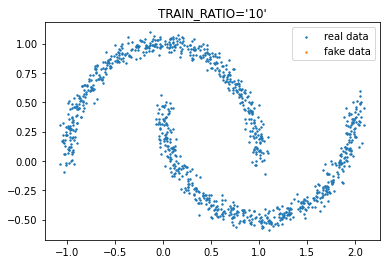

In [ ]:

# Total number of training iterations for the generator
N_ITER = 5001
# Batch size to use
BATCHLEN = 128

for train_ratio in [1, 2, 5, 10]:
    print(f"Training GAN TRAIN_RATIO={train_ratio}...")
    generator = Generator(hidden_layers=[16, 32])
    discriminator = Discriminator(hidden_layers=[256, 128, 64])
    gen_losses, disc_losses = train_gan(generator, discriminator, train_ratio, N_ITER, BATCHLEN)
    plot_gan(generator, title=f"TRAIN_RATIO='{train_ratio}'")


**Interpretation:**

As expected from the previous questions, we can see during these trainings that the higher the value of `TRAIN_RATIO` the faster the algorithm diverges (reaches 'nan' losses).



For further readings on GANs, you can see the following papers:

- Generative Adversarial Networks *(Goodfellow et al.)*: [arXiv:1406.2661](https://arxiv.org/abs/1406.2661)
- Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks *(Radford et al.)*: [arXiv:1511.06434](https://arxiv.org/abs/1511.06434)
- A Style-Based Generator Architecture for Generative Adversarial Networks *(Karras et al.)* [arxiv:1812.04948v3](https://arxiv.org/abs/1812.04948v3)

### Variational AutoEncoders

Another well-known approach to generative modelling is embodied by Variational AutoEncoders (VAEs). While the generative model itself and the procedure to sample it is similar to GANs, the way it is trained is not.

The main goal of VAEs is to optimize the likelihood of the real data according to the generative model. In other words, maximize $\mathbb{E}_{p_D} \left[\log p_\theta(x) \right ]$, which is equivalent to minimizing $D_{KL}(p_D \| p_\theta)$.
$$D_{KL}(p_D \| p_\theta) = \mathbb{E}_{p_D}\left[ log(\frac{p_D}{p_\theta}) \right]$$

**Q8: Prove this equivalence.**

First, maximizing $\mathbb{E}_{p_D} \left[\log p_\theta(x) \right ]$ is equivalent to minimizing

$$
-\mathbb{E}_{p_D} \left[\log p_\theta(x) \right ] = \mathbb{E}_{p_D} \left[\log \frac{1}{p_\theta(x)} \right ]
$$

And since $\mathbb{E}_{p_D} \left[\log p_D(x) \right ]$ is a constant, it is also equivalent to minimizing 

$$
\mathbb{E}_{p_D} \left[\log \frac{1}{p_\theta(x)} \right ] + \mathbb{E}_{p_D} \left[\log p_D(x) \right ] = \mathbb{E}_{p_D}\left[ log(\frac{p_D(x)}{p_\theta(x)}) \right] = D_{KL}(p_D \| p_\theta)
$$

However, the classes of distributions for which $\log p_\theta(x)$ can be analytically computed and optimized is very restricted, and not suitable for real world problems. The main idea of the VAE is thus to introduce a latent variable $z$ and decompose the distribution as: $p_\theta(x, z) = p_\theta(x | z) p(z)$. Here $p(z)$ is some fixed prior and $p_\theta(x | z)$ is a simple distribution whose parameters are the output of a neural network.

For example, you could have $p(z)$ be a standard $\mathcal{N}(0;1)$ and $p_\theta(x | z)$ be defined as a gaussian $\mathcal{N}(\mu_\theta(z); \sigma_\theta(z))$ where $\mu_\theta(z)$ and $\sigma_\theta(z)$ are created by the neural network you will train. In this case, the resulting distribution $p_\theta(x) = \int_z p_\theta(x|z)p(z)dz$ is an infinite mixture of Gaussians, which is a much more expressive class of distributions.

Now, this cannot stop here, as we are not able to analitically compute the density $p_\theta(x)$. The second main idea of the VAE is to introduce another, auxilliary distribution: $q_\phi(z | x)$, which will be modelled by a neural network similarly to $p_\theta(x | z)$. Introducing it allows us to create a lower bound for $\log p_\theta(x)$:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log p_\theta(x) \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Following Bayes theorem, $p_\theta(x) p_\theta(z|x) = p_\theta(x, z) = p_\theta(x|z) p(z)$, so we get:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log \frac{p_\theta(x|z) p(z)}{p_\theta(z|x)} \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Re-organizing the terms:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log \frac{q_\phi(z|x)}{p_\theta(z|x)} + \mathbb{E}_{z \sim q_\phi} \log \frac{p(z)}{q_\phi(z|x)} + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x | z)$$

This can be re-expressed like so:

$$\log p_\theta(x) = D_{KL}(q_\phi(z | x) \| p_\theta(z | x)) - D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x|z)$$

The 3 terms of this equality can be interpreted like so:

- the first term measures how much $q_\phi(z | x)$ is similar to $p_\theta(z | x)$, or in other words is a good inverse of $p_\theta(x | z)$
- the second term measures how similar $q_\phi(z|x)$ is from the latent prior $p(z)$
- the third term is linked to how likely $p_\theta$ is to yield the given $x$ when $z$ is sampled from $q_\phi(z | x)$ rather than $p(z)$

It is interesting to note that the first term, being a KL-divergence is always positive. As such the combination of the last two terms forms a lower bound of $\log p_\theta(x)$ which *can* be computed and used as a training objective. This bound is called the *Evidence Lower-Bound (ELBO)*. Simply flipping its sign can make it into a loss that can be minimized by gradient descent:

$$ \mathcal{L}_{ELBO} = D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} [ - \log p_\theta(x|z) ]$$

From this formulation comes the parallel with auto-encoders that give the VAE its name: $q_\phi(z | x)$ can be seen as a *probabilistic encoder* from the data $x$ to the latent space $z$, and $p_\theta(x | z)$ can be seen as a *probabilistic decoder* from the latent space $z$ to the data $x$. In this case the second term of $\mathcal{L}_{ELBO}$ is the loss measuring the reconstruction quality of the auto-encoder, and the first term can be seens as a regularization of the latent space.

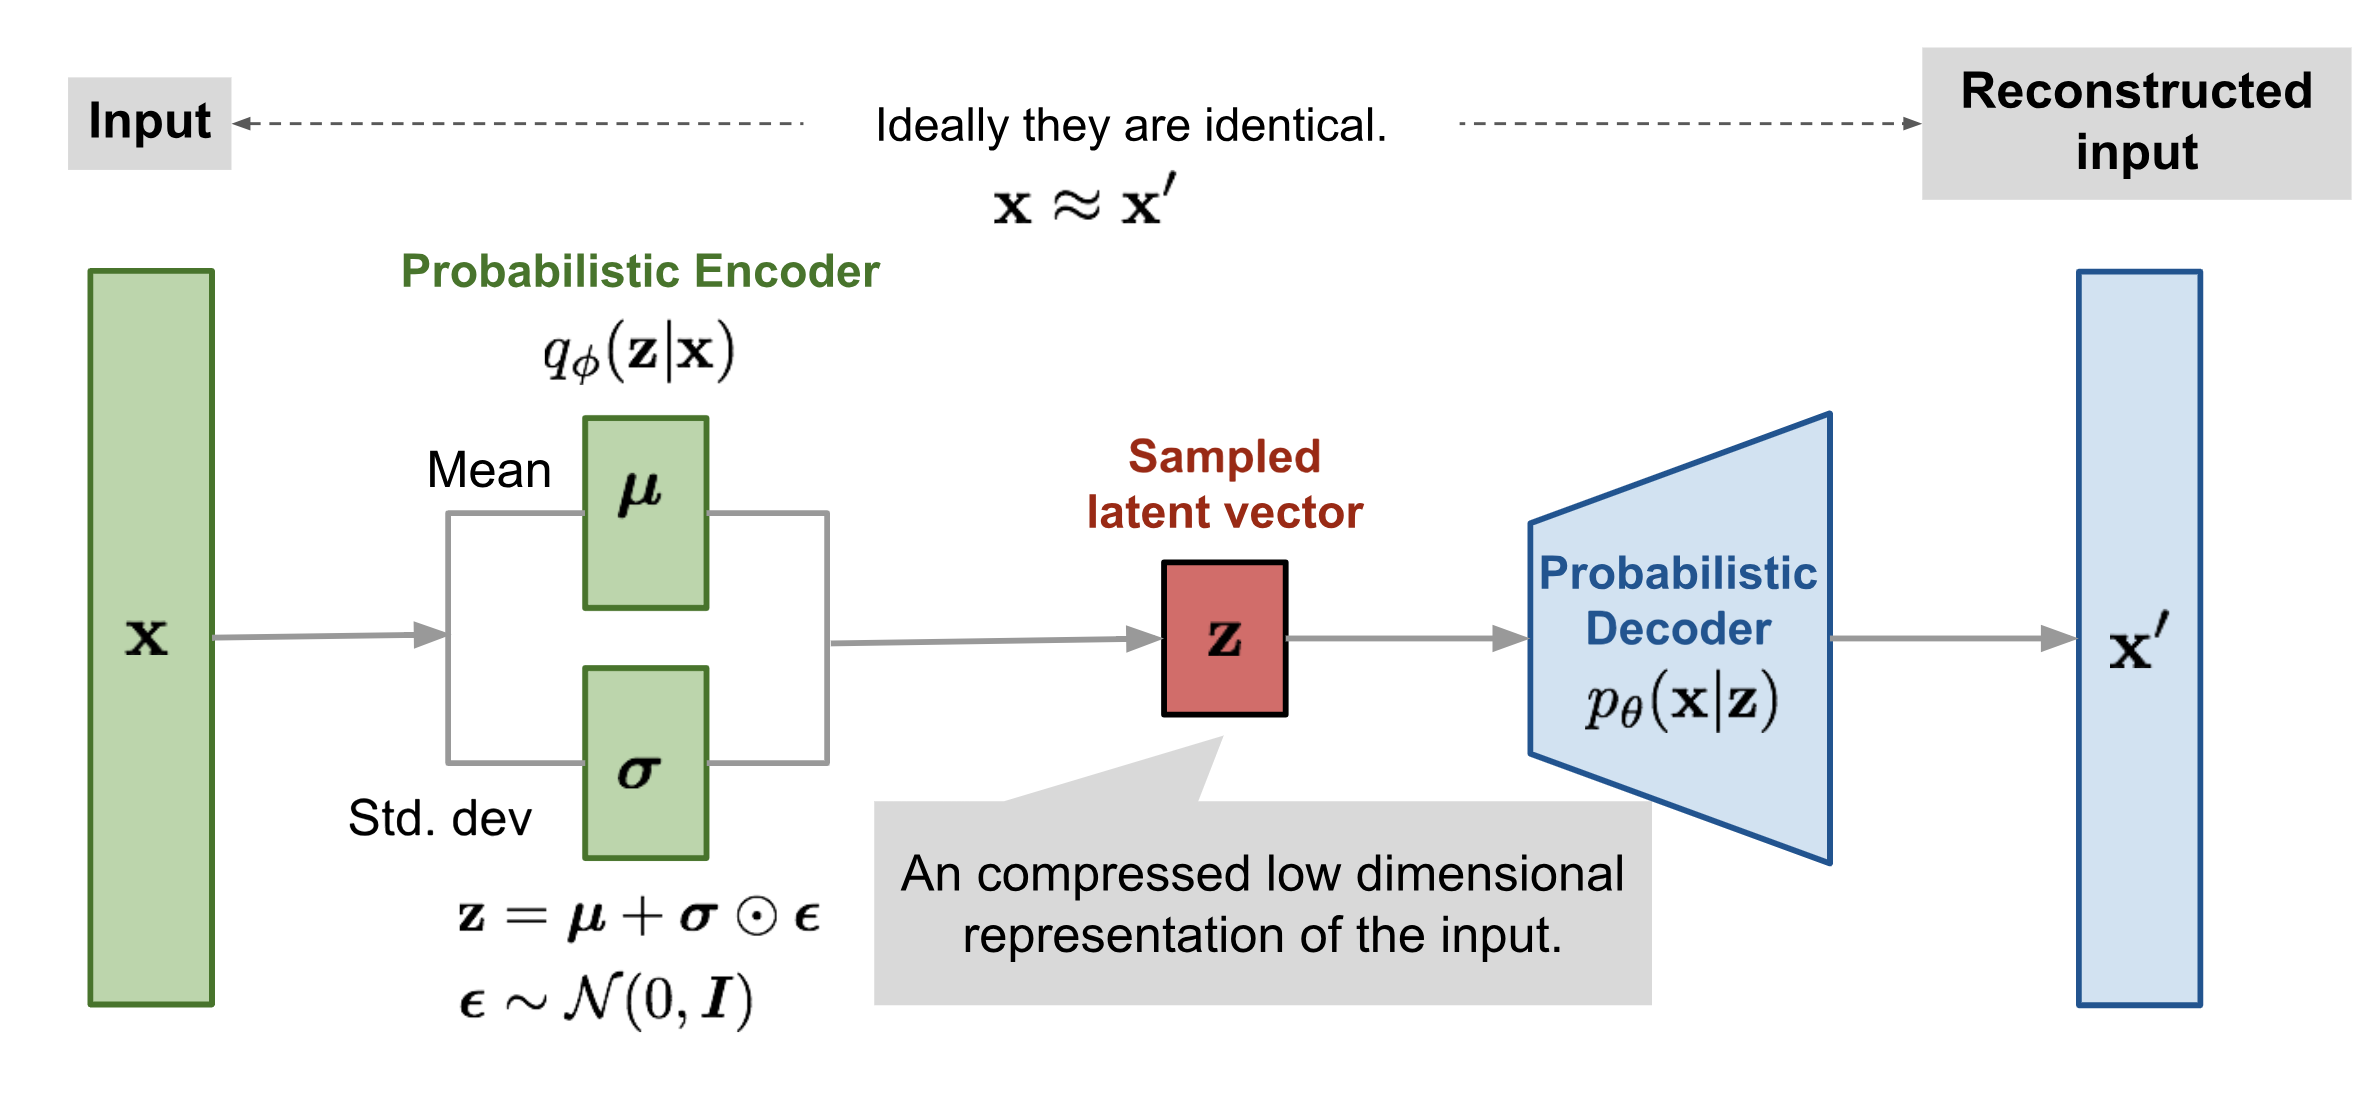

**Q9: We can see that $p(z)$ is never sampled during the training process, how can that be a problem?**

The problem with never sampling $p(z)$ is that we assume it is a unit distribution but we can never check it. This distribution could diverge and impact the convergence of the VAE. In practice we might need to add a regularization factor to avoid large values in $z$

A typical choice to represent $q_\phi(z | x)$ is to use a diagonal Gaussian distribution $\mathcal{N}(\mu_\phi(x); Diag(\sigma_\phi^2(x)))$, which makes the KL-divergence term of $\mathcal{L}_{ELBO}$ analytically computable.

**Q10: Assuming $p(z)$ is a $\mathcal{N}(0; Id)$ gaussian, what is the value of $D_{KL}(q_\phi(z | x) \| p(z))$?**

Assuming $p(z)$ is a $\mathcal{N}(0; Id)$ gaussian,

$$
\mathbb{E}_q\left[ \log(p(z) \right] = \mathbb{E}_q\left[ log \left( \prod_{i=1}^N \frac{1}{\sqrt{2\pi}} e^{-\frac{x_i^2}{2}} \right) \right] = \mathbb{E}_q\left[ - \frac{N}{2}log(2 \pi) - \sum_{i=1}^N \frac{x_i^2}{2} \right] = - \frac{N}{2}log(2 \pi) - \frac{1}{2} \sum_{i=1}^N \mathbb{E}_q\left[x_i^2 \right]
$$

With $N$ the dimension of $z$.

However, we have for all $i$:

$$
\mathbb{E}_q\left[x_i^2 \right] = \mathbb{E}_q\left[(x_i - \mu_i + \mu_i)^2 \right] = \mathbb{E}_q\left[(x_i - \mu_i)^2 + 2\mu_i(x_i-\mu_i) + \mu_i^2\right] = \sigma_i^2 + \mu_i^2 + 2\mu_i\mathbb{E}_q\left[x_i-\mu_i \right] = \sigma_i^2 + \mu_i^2 + 2\mu_i(\mu_i-\mu_i) = \sigma_i^2 + \mu_i^2
$$

Where $\mu_i = \mu_\phi(x)^{(i)}$ and $\sigma_i^2 = \sigma_\phi^2(x)^{(i)}$. Hence:

$$
\mathbb{E}_q\left[ \log(p(z) \right] = - \frac{N}{2}log(2 \pi) - \frac{1}{2} \sum_{i=1}^N \sigma_i^2 + \mu_i^2
$$

In the same way, with $q_\phi(z | x)$ modeled as a diagonal Gaussian $\mathcal{N}(\mu_\phi(x); Diag(\sigma_\phi^2(x)))$,

$$
\mathbb{E}_q\left[ \log(q_\phi(z | x)) \right] = \mathbb{E}_q\left[ - \frac{N}{2}log(2 \pi) - \frac{1}{2} \sum_{i=1}^N log\left(\sigma_i^2 \right) + \left(\frac{x_i - \mu_i}{\sigma_i}\right)^2 \right] = - \frac{N}{2}log(2 \pi) -  \frac{1}{2} \sum_{i=1}^N log\left(\sigma_i^2 \right) + \frac{1}{\sigma_i^2} \mathbb{E}_q\left[(x_i - \mu_i)^2 \right] = - \frac{N}{2}log(2 \pi) -  \frac{1}{2} \sum_{i=1}^N log\left(\sigma_i^2 \right) + 1
$$

Hence,

$$
D_{KL}(q_\phi(z | x) \| p(z)) = \mathbb{E}_q\left[ \log(q_\phi(z | x)) \right] - \mathbb{E}_q\left[ \log(p(z) \right] = - \frac{1}{2} \sum_{i=1}^N \left( 1 + log (\sigma_i^2) - \sigma_i^2 - \mu_i^2)\right)
$$


We will also model $p_\theta(x | z)$ as a diagonal Gaussian $\mathcal{N}(\mu_\theta(z); Diag(\sigma_\theta^2(z)))$.


**Note:** For the following, be careful about the difference between $\mu_\phi, \sigma_\phi$ which define the Gaussian distribution of the *encoder* $q_\phi$ and $\mu_\theta, \sigma_\theta$ which define the Gaussian distribution of the *decoder* $p_\theta$.

**Q11: What is the expression of $-\log p_\theta(x | z)$ for given $x$ and $z$?**

With $p_\theta(x | z)$ modeled as a diagonal Gaussian $\mathcal{N}(\mu_\theta(z); Diag(\sigma_\theta^2(z)))$, we have:

$$
-\log p_\theta(x | z) = - \log \left( \prod_{i=1}^N \frac{1}{\sigma_\theta(z)^{(i)}\sqrt{2\pi}} e^{-\frac{1}{2} \left(\frac{x_i - \mu_\theta(z)^{(i)}}{\sigma_\theta(z)^{(i)}} \right)^2} \right) = \frac{1}{2} \sum_{i=1}^N log \left(2 \pi \sigma_\theta^2(z)^{(i)} \right)  + \left(\frac{x_i - \mu_\theta(z)^{(i)}}{\sigma_\theta(z)^{(i)}} \right)^2
$$



We will build and train a VAE using the same dataset as previously, in order to compare its behavior to GANs. For numerical stability, we will interpret the output of the encoder and decoder networks as $(\mu, \log\sigma^2)$, rather than $(\mu, \sigma)$.

In [7]:

def generate_model(input_dim, output_dim, hidden_layers, 
                   add_relu=True, activation=None):
    layers = []
    if len(hidden_layers) == 0:
        layers += [nn.Linear(input_dim, output_dim)]
    else:
        layers += [nn.Linear(input_dim, hidden_layers[0])]
        if add_relu:
            layers += [nn.ReLU()]
        for i in range(len(hidden_layers)-1):
            layers += [nn.Linear(hidden_layers[i], hidden_layers[i+1])]
            if add_relu:
                layers += [nn.ReLU()]
        layers += [nn.Linear(hidden_layers[-1], output_dim)]
    if activation is not None:
        layers += [activation]
    return nn.Sequential(*layers)


In [8]:
# Choose a value for the latent dimension
LATENT_N = 2

# Define the generator
class Encoder(nn.Module):
    def __init__(self, hidden_layers=[]):
        super().__init__()
        self.fc_mu = generate_model(2, LATENT_N, hidden_layers)
        self.fc_logvar = generate_model(2, LATENT_N, hidden_layers)
        
    # encode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian q_\phi(z | x)
    def __call__(self, x):
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return (mu, logvar)
    

# Define the discriminator
class Decoder(nn.Module):
    def __init__(self, hidden_layers=[]):
        super().__init__()
        self.fc_mu = generate_model(LATENT_N, 2, hidden_layers)
        self.fc_logvar = generate_model(LATENT_N, 2, hidden_layers)
    
    # decode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian p_\theta(z | x)
    def __call__(self, z):
        mu = self.fc_mu(z)
        logvar = self.fc_logvar(z)
        return (mu, logvar)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, LATENT_N), 1.0)
        (mu, logvar) = self.__call__(z)
        return torch.normal(mu, torch.exp(0.5*logvar))

From this, the parameters of both networks are trained conjointly using the same loss $\mathcal{L}_{ELBO}$. 

step 0: KL: 1.131e+01, rec: 4.231e+02


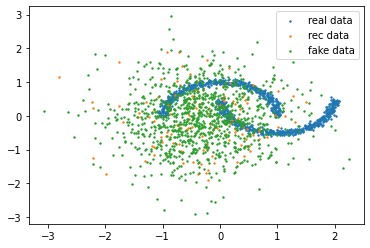

step 1000: KL: 1.361e-04, rec: 2.568e+02


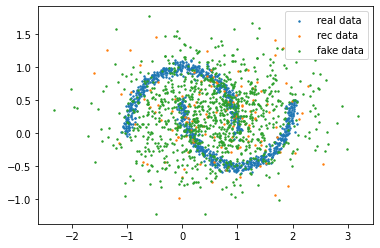

step 2000: KL: 9.829e-05, rec: 2.552e+02


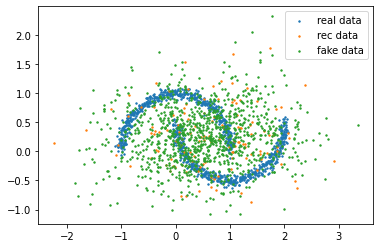

step 3000: KL: 1.329e-05, rec: 2.551e+02


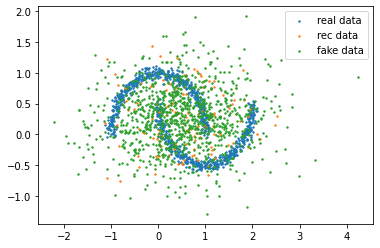

step 4000: KL: 8.178e-05, rec: 2.550e+02


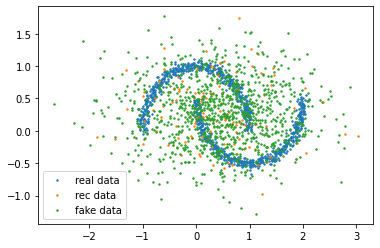

step 5000: KL: 4.643e-05, rec: 2.540e+02


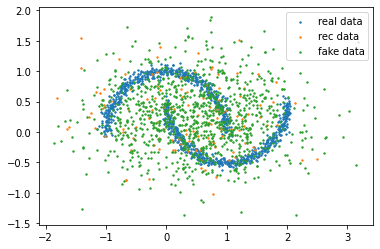

step 6000: KL: 4.464e-05, rec: 2.555e+02


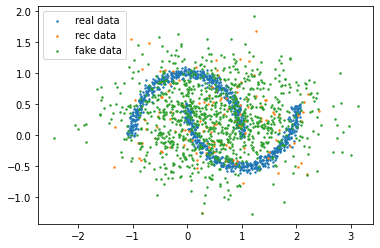

step 7000: KL: 1.476e-04, rec: 2.559e+02


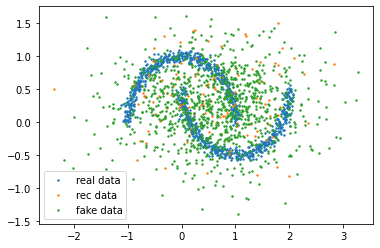

step 8000: KL: 2.629e-05, rec: 2.551e+02


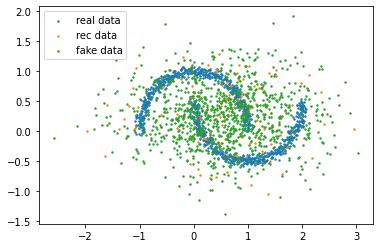

step 9000: KL: 8.166e-06, rec: 2.540e+02


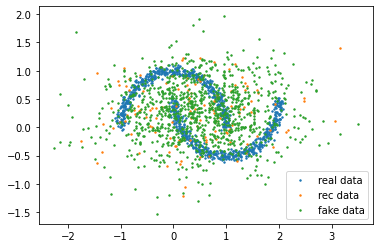

step 10000: KL: 2.718e-05, rec: 2.529e+02


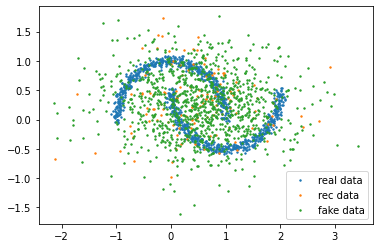

In [11]:
# Total number of training iterations for the VAE
N_ITER = 10001
# Batch size to use
BATCHLEN = 128

encoder = Encoder(hidden_layers=[8])
optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(0.5,0.9))
decoder = Decoder(hidden_layers=[8])
optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.001, betas=(0.5,0.9))

for i in range(N_ITER):
    encoder.zero_grad()
    decoder.zero_grad()
    
    x = generate_batch(BATCHLEN)
    
    enc_mu, enc_logvar = encoder(x)
    #
    # COMPUTE THE KL PART OF THE LOSS HERE
    #
    loss_kl = -0.5 * torch.sum(1 + enc_logvar - enc_mu.pow(2) - enc_logvar.exp())
    #
    # SAMPLE z FROM q(z|x) HERE
    #
    z = torch.normal(enc_mu, torch.exp(0.5*enc_logvar))

    dec_mu, dec_logvar = decoder(z)
    #
    # COMPUTE THE RECONSTRUCTION PART OF THE LOSS HERE
    #
    dist = torch.distributions.Normal(dec_mu, torch.exp(0.5*dec_logvar))
    # dist = torch.distributions.Normal(dec_mu, 1e-4)
    loss_rec = - dist.log_prob(x).sum()
    # loss_rec = 0.5 * torch.sum(dec_logvar + (x-dec_mu).pow(2) / dec_logvar.exp())
    
    (0.5 * loss_kl + 0.5 * loss_rec).backward()
    optim_enc.step()
    optim_dec.step()
    if i%1000 == 0:
        print('step {}: KL: {:.3e}, rec: {:.3e}'.format(i, float(loss_kl), float(loss_rec)))
        # plot the result
        real_batch = generate_batch(1024)
        rec_batch = torch.normal(dec_mu, torch.exp(0.5*dec_logvar)).detach()
        fake_batch = decoder.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, label='rec data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()

**Q12: Try hardcoding $\sigma_\theta(z)$ to some small value (like 1E-4) rather than allowing the decoder to learn it. What does it change?**

When hardcoding $\sigma_\theta(z)$ to some small value, the reconstuction loss gets even higher than without (in the range of $10^9$ versus $10^2$ without hardcoding. Thus, this constrainst worsten the fiting of the VAE model.

**Q13: How do the power of encoder and decoder affect the overall training of the VAE?**

Even when giving much power to the decoder to reduce the reconstruction loss (by increasing the weight of the reconstruction loss or by increasing the complexity of the model), the result of the VAE is not satrisfying enough to fit the two moons correctly.

### Normalizing flows

Another approach to generative modelling is given by Normalizing flows. The idea is to learn a mapping $f$ from the data distribution $p_D$ (defined over a space $\mathcal{X}$) to a known distribution (typically, a normal distribution) from which we know how to sample. Two key points are to be noted:
1. The mapping needs to be bijective (i.e., the network needs to be invertible).
2. The exact likelihood of a data point should be easily computable.

To tackle point 2, let us introduce some notations.
Let us denote by $p_\mathcal{N} = \mathcal{N}(0,1)$ the normal distribution from which we sample $z$. We obtain points $x$ by computing $x = f^{-1}(z)$, and we hope that the distribution of points obtained this way will match more or less the dataset distribution $p_D$ of real examples.
We denote by $p_G$ this obtained distribution, that is, the image of $p_\mathcal{N}$ through $f^{-1}$: $p_G$ is a probability distribution defined on $\mathcal{X}$, and our goal will be to optimize the mapping $f$ so that $p_G$ is close to $p_D$. If you are not familiar with images of distributions, the definition is here: https://en.wikipedia.org/wiki/Pushforward_measure ; it can be defined as the measure that satisfies this change of variables: $\int_{z\sim p_\mathcal{N}} g(f^{-1}(z)) dz = \int_{x\sim p_{G}} g(x) dx$ for all functions $g$. Another notation for this is $\int_{z} g(f^{-1}(z)) \;dp_\mathcal{N}(z) = \int_{x} g(x) \;dp_{G}(x)$. 
We will build on the following identity:
$$
\log(p_X(x))=\log(p_Z(z))+\log \det J_f
$$
where $J_f = \frac{df(x)}{dx}$ is the Jacobian matrix of the function $f$.

**Q14: Justify the above equality**


From the definition of the distributions, we have

$$
\int_{x} p_X(x) dx = \int_{z} p_Z(z) dz = 1
$$

So, with a change of variable, we have

$$
p_X(x) = p_Z(z) \left|det \frac{dz}{dx}\right| = p_Z(z) \left|det \frac{df^{-1}(x)}{dx}\right| = p_Z(z) |det(J_f)|
$$

Hence,

$$
\log(p_X(x))=\log(p_Z(z))+\log \det J_f
$$


Let us consider, as an optimization criterion, the Kullback-Leibler divergence $KL(p_D||p_G)$.

**Q15: Express this loss as a (very simple) function of the quantity above.**


From the previous expression, we instantly have

$$
KL(p_D||p_G) = \log(p_D) - \log(p_G) = \log \det J_f
$$


A challenging task is then to find a network, such that f is:
* invertible
* $\det J_f$ is tractable
* $f$ is general enough

A common architecture is the so called real-valued non-volume preserving (real-NVP), which is made of coupling layers.

The idea of coupling layers is to cut the input $x$ in two (let say keeping only the $d < D$ first dimensions on one hand and the $D-d$ other dimensions on the other hand, with $D$ the dimension of the input space $\mathcal{X}$). This gives inputs $x_{1:d}$ and $x_{d+1:D}$. Then the forward pass is defined as:
* $y_{1:d}=x_{1:d}$
* $y_{d+1:D}=x_{d+1:D}\odot \exp(s(x_{1:d})) + t(x_{1:d})$

where $s,t:\mathbb{R}^d\to\mathbb{R}^{D-d}$ and $\odot$ is the coefficient-wise multiplication of two vectors of the same size.

Those equations can be resumed in the following diagram:
![real NVP diagram](realNVPforward.png)

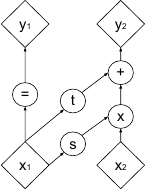

**Q16: Show that the defined mapping is indeed invertible**


The first part of the output is obviously revertible, we simply have $x_1 = y_1$.

As for the second part,

$$
y_2 = x_2 \odot \exp(s(x_1)) + t(x_1) = x_2 \odot \exp(s(y_1)) + t(y_1)
$$

Thus, after computing $\exp(s(y_1))$, we can find $x_2$ from $y_1$ and $y_2$ with a coefficient-wise division of $y2 - t(y_1)$ by $\exp(s(y_1))$.


**Q17: Show that the determinant of the Jacobian of such a mapping is $\exp(\sum_j s(x_{1:d})_j)$**


Now, our Jacobian became

$$
J_f = 
\begin{bmatrix}
I_d & O_{d \times (D-d)} \\
\frac{\partial y_2}{\partial x_1} & Diag(exp(s(x_1)))
\end{bmatrix}
$$

Thus, the determinant of the Jacobian is simply

$$
det(J_f) = \prod_j exp(s(x_1)_j) = exp \left(\sum_j s(x_1)_j \right)
$$


**Q18: Fill the Coupling layer structure below by defining suitable functions sfun and tfun (using a final tanh in sfun is highly recommended) and the inverse pass**

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F


class CouplingLayer(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, mask):
        super().__init__()
        ### define here variables to use in f and s ###
        self.s_lin_1 = nn.Linear(input_size, hidden_size)
        self.s_lin_2 = nn.Linear(hidden_size, output_size)
        self.t_lin_1 = nn.Linear(input_size, hidden_size)
        self.t_lin_2 = nn.Linear(hidden_size, output_size)
        ###
        self.mask = mask #we use the mask variable to make the cut in input

    def sfun(self, x_m):
        for layer in [self.s_lin_1, self.s_lin_2]:
            x_m = layer(x_m)
        return torch.tanh(x_m)
        
    def tfun(self, x_m):
        return self.t_lin_2(self.t_lin_1(x_m))
        
    def forward(self, x):
        x_m = x * self.mask
        s_out = self.sfun(x_m) # multiplicative block
        t_out = self.tfun(x_m) # additive block
        y = x_m + (1-self.mask)*(x*torch.exp(s_out)+t_out)
        log_det_jacobian = s_out.sum(dim=1)  # CRITICAL
        return y, log_det_jacobian

    def inverse(self, y):
        return y

In [ ]:
class RealNVP(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, mask, n_layers=6):
        super().__init__()
        assert n_layers >= 2, "num of coupling layers should be greater or equal to 2"

        self.modules = []
        self.modules.append(CouplingLayer(input_size, output_size, hidden_size, mask))
        for _ in range(n_layers-2):
            mask = 1 - mask
            self.modules.append(CouplingLayer(input_size, output_size, hidden_size, mask))
        self.modules.append(CouplingLayer(input_size, output_size, hidden_size, 1 - mask))
        self.module_list = nn.ModuleList(self.modules)

    def forward(self, x):
        ldj_sum = 0  # sum of log determinant of jacobian
        for module in self.module_list:
            x, ldj = module(x)
            ldj_sum += ldj
        return x, ldj_sum

    def inverse(self, z):
        for module in reversed(self.module_list):
            z = module.inverse(z)
        return z

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch


def train(epoch, model, optimizer, prior_z, train_loader, log_interval=50):
    model.train()
    train_loss = 0
    for batch_idx, x_inputs in enumerate(train_loader):
        optimizer.zero_grad()
        z_outputs, log_det_j_sum = model.forward(x_inputs)  # train with the forward
        loss = -(prior_z.log_prob(z_outputs)+log_det_j_sum).mean()  # CRITICAL
        loss.backward()
        cur_loss = loss.item()
        train_loss += cur_loss
        optimizer.step()
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(x_inputs), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), cur_loss / len(x_inputs)))

    average_train_loss = train_loss / len(train_loader.dataset)
    print(f"====> Epoch: {epoch} Average train loss: {average_train_loss:.4f}")


def test(epoch, model, prior_z, test_loader):
    model.eval()
    test_loss = 0
    x_all = np.array([[]]).reshape(0, 2)
    z_all = np.array([[]]).reshape(0, 2)
    with torch.no_grad():
        for batch_idx, x_inputs in enumerate(test_loader):
            z_outputs, log_det_j_sum = model.forward(x_inputs)
            cur_loss = -(prior_z.log_prob(z_outputs)+log_det_j_sum).mean().item()
            test_loss += cur_loss
            x_all = np.concatenate((x_all, x_inputs.numpy()))
            z_all = np.concatenate((z_all, z_outputs.numpy()))

        subfig_plot(1, x_all, -2, 3, -1, 1.5, "Input: x ~ p(x)", "b")
        subfig_plot(2, z_all, -3, 3, -3, 3, "Output: z = f(x)", "b")

        test_loss /= len(test_loader.dataset)
        print(f"====> Test loss: {test_loss:.4f}")


def sample(epoch, model, prior_z, save_plt_interval=5):
    model.eval()
    with torch.no_grad():
        z_inputs = prior_z.sample((1000,))
        x_outputs = model.inverse(z_inputs)  # generation with the inverse
        z_inputs = z_inputs.numpy()
        x_outputs = x_outputs.numpy()

        subfig_plot(3, z_inputs, -3, 3, -3, 3, "Input: z ~ p(z)", "r")
        subfig_plot(4, x_outputs, -2, 3, -1, 1.5, "Output: x = g(z) (g: inverse of f)", "r")

        if epoch % save_plt_interval == 0:
            if not os.path.exists("results"):
                os.makedirs("results")
            plt.savefig("results/"+"result_"+str(epoch)+".png")


def subfig_plot(location, data, x_start, x_end, y_start, y_end, title, color):
    if location == 1:
        plt.clf()
    plt.subplot(2, 2, location)
    plt.scatter(data[:, 0], data[:, 1], c=color, s=1)
    plt.xlim(x_start, x_end)
    plt.ylim(y_start, y_end)
    plt.title(title)
    plt.pause(1e-2)

In [ ]:
# globals
BATCH_SIZE = 128
LOG_INTERVAL = 50
N_EPOCHS = 10
INPUT_SIZE = 2
OUTPUT_SIZE = 2
HIDDEN_SIZE = 8
SAVE_PLT_INTERVAL = 5
N_COUPLING_LAYERS = 4

In [ ]:
# data loading
train_data = datasets.make_moons(n_samples=50000, noise=.05)[0].astype(np.float32)
test_data = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loader_kwargs = {"num_workers": 1, "pin_memory": True} if device == "cuda" else {}
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs)

In [ ]:
from torch import distributions # optim, 
# model construction
mask = torch.from_numpy(np.array([0, 1]).astype(np.float32))
model = RealNVP(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_SIZE, mask, N_COUPLING_LAYERS)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
prior_z = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))

Train Epoch: 1 [0/50000 (0%)]	Loss: 0.014306
Train Epoch: 1 [6400/50000 (13%)]	Loss: 0.011284
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.010000
Train Epoch: 1 [19200/50000 (38%)]	Loss: 0.008838
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.007730
Train Epoch: 1 [32000/50000 (64%)]	Loss: 0.006610
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.005362
Train Epoch: 1 [44800/50000 (90%)]	Loss: 0.004796
====> Epoch: 1 Average train loss: 0.0083


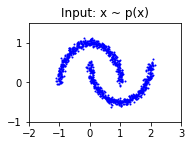

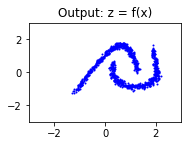

====> Test loss: 0.0034


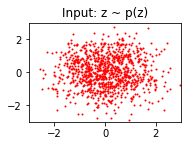

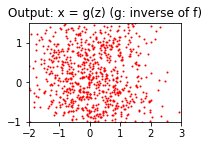

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.004021
Train Epoch: 2 [6400/50000 (13%)]	Loss: 0.001731
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.001181
Train Epoch: 2 [19200/50000 (38%)]	Loss: 0.001005
Train Epoch: 2 [25600/50000 (51%)]	Loss: -0.000142
Train Epoch: 2 [32000/50000 (64%)]	Loss: -0.000996
Train Epoch: 2 [38400/50000 (77%)]	Loss: -0.001856
Train Epoch: 2 [44800/50000 (90%)]	Loss: -0.001779
====> Epoch: 2 Average train loss: 0.0001


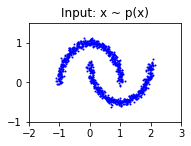

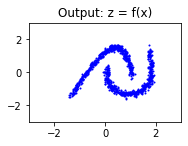

====> Test loss: -0.0026


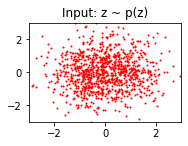

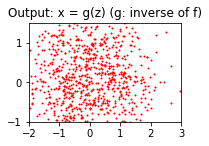

Train Epoch: 3 [0/50000 (0%)]	Loss: -0.002382
Train Epoch: 3 [6400/50000 (13%)]	Loss: -0.003338
Train Epoch: 3 [12800/50000 (26%)]	Loss: -0.003898
Train Epoch: 3 [19200/50000 (38%)]	Loss: -0.003949
Train Epoch: 3 [25600/50000 (51%)]	Loss: -0.005182
Train Epoch: 3 [32000/50000 (64%)]	Loss: -0.005124
Train Epoch: 3 [38400/50000 (77%)]	Loss: -0.005507
Train Epoch: 3 [44800/50000 (90%)]	Loss: -0.005612
====> Epoch: 3 Average train loss: -0.0045


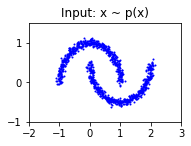

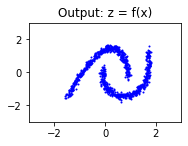

====> Test loss: -0.0064


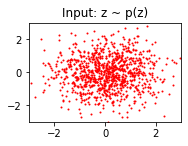

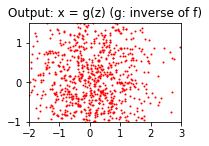

Train Epoch: 4 [0/50000 (0%)]	Loss: -0.006271
Train Epoch: 4 [6400/50000 (13%)]	Loss: -0.006238
Train Epoch: 4 [12800/50000 (26%)]	Loss: -0.007017
Train Epoch: 4 [19200/50000 (38%)]	Loss: -0.007254
Train Epoch: 4 [25600/50000 (51%)]	Loss: -0.007257
Train Epoch: 4 [32000/50000 (64%)]	Loss: -0.008174
Train Epoch: 4 [38400/50000 (77%)]	Loss: -0.008048
Train Epoch: 4 [44800/50000 (90%)]	Loss: -0.008339
====> Epoch: 4 Average train loss: -0.0076


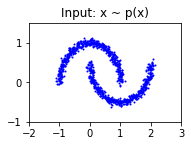

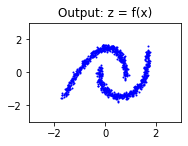

====> Test loss: -0.0091


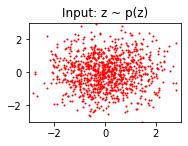

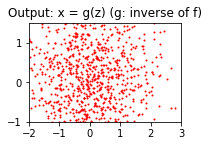

Train Epoch: 5 [0/50000 (0%)]	Loss: -0.008678
Train Epoch: 5 [6400/50000 (13%)]	Loss: -0.008974
Train Epoch: 5 [12800/50000 (26%)]	Loss: -0.009301
Train Epoch: 5 [19200/50000 (38%)]	Loss: -0.010014
Train Epoch: 5 [25600/50000 (51%)]	Loss: -0.009994
Train Epoch: 5 [32000/50000 (64%)]	Loss: -0.010482
Train Epoch: 5 [38400/50000 (77%)]	Loss: -0.010956
Train Epoch: 5 [44800/50000 (90%)]	Loss: -0.010919
====> Epoch: 5 Average train loss: -0.0099


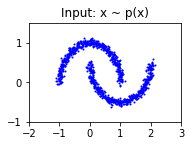

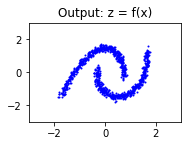

====> Test loss: -0.0111


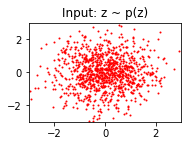

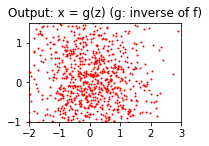

Train Epoch: 6 [0/50000 (0%)]	Loss: -0.010849
Train Epoch: 6 [6400/50000 (13%)]	Loss: -0.011530
Train Epoch: 6 [12800/50000 (26%)]	Loss: -0.011402
Train Epoch: 6 [19200/50000 (38%)]	Loss: -0.011841
Train Epoch: 6 [25600/50000 (51%)]	Loss: -0.011614
Train Epoch: 6 [32000/50000 (64%)]	Loss: -0.011512
Train Epoch: 6 [38400/50000 (77%)]	Loss: -0.011328
Train Epoch: 6 [44800/50000 (90%)]	Loss: -0.012962
====> Epoch: 6 Average train loss: -0.0116


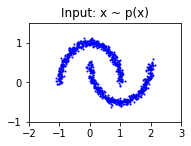

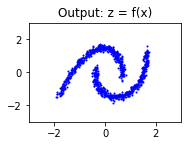

====> Test loss: -0.0126


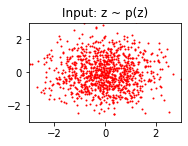

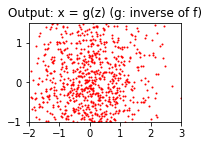

Train Epoch: 7 [0/50000 (0%)]	Loss: -0.012334
Train Epoch: 7 [6400/50000 (13%)]	Loss: -0.012321
Train Epoch: 7 [12800/50000 (26%)]	Loss: -0.012078
Train Epoch: 7 [19200/50000 (38%)]	Loss: -0.012650
Train Epoch: 7 [25600/50000 (51%)]	Loss: -0.012564
Train Epoch: 7 [32000/50000 (64%)]	Loss: -0.013110
Train Epoch: 7 [38400/50000 (77%)]	Loss: -0.013449
Train Epoch: 7 [44800/50000 (90%)]	Loss: -0.013491
====> Epoch: 7 Average train loss: -0.0129


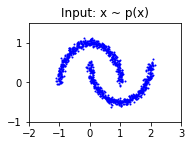

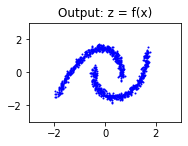

====> Test loss: -0.0137


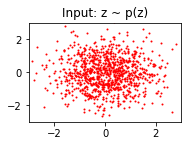

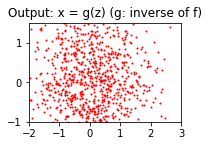

Train Epoch: 8 [0/50000 (0%)]	Loss: -0.012963
Train Epoch: 8 [6400/50000 (13%)]	Loss: -0.013191
Train Epoch: 8 [12800/50000 (26%)]	Loss: -0.014455
Train Epoch: 8 [19200/50000 (38%)]	Loss: -0.013563
Train Epoch: 8 [25600/50000 (51%)]	Loss: -0.013646
Train Epoch: 8 [32000/50000 (64%)]	Loss: -0.013993
Train Epoch: 8 [38400/50000 (77%)]	Loss: -0.013033
Train Epoch: 8 [44800/50000 (90%)]	Loss: -0.014920
====> Epoch: 8 Average train loss: -0.0138


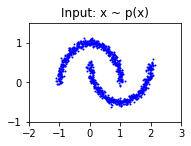

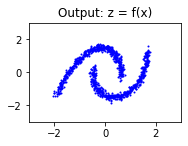

====> Test loss: -0.0145


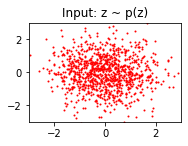

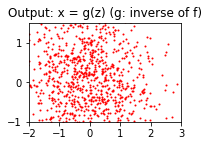

Train Epoch: 9 [0/50000 (0%)]	Loss: -0.014237
Train Epoch: 9 [6400/50000 (13%)]	Loss: -0.014276
Train Epoch: 9 [12800/50000 (26%)]	Loss: -0.014565
Train Epoch: 9 [19200/50000 (38%)]	Loss: -0.014777
Train Epoch: 9 [25600/50000 (51%)]	Loss: -0.014425
Train Epoch: 9 [32000/50000 (64%)]	Loss: -0.014820
Train Epoch: 9 [38400/50000 (77%)]	Loss: -0.014577
Train Epoch: 9 [44800/50000 (90%)]	Loss: -0.014258
====> Epoch: 9 Average train loss: -0.0145


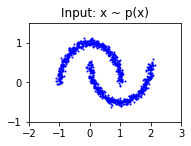

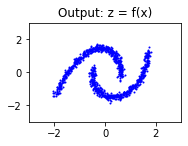

====> Test loss: -0.0151


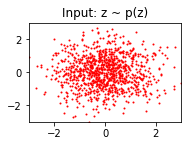

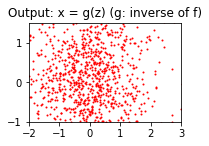

Train Epoch: 10 [0/50000 (0%)]	Loss: -0.015008
Train Epoch: 10 [6400/50000 (13%)]	Loss: -0.015028
Train Epoch: 10 [12800/50000 (26%)]	Loss: -0.014548
Train Epoch: 10 [19200/50000 (38%)]	Loss: -0.015562
Train Epoch: 10 [25600/50000 (51%)]	Loss: -0.015325
Train Epoch: 10 [32000/50000 (64%)]	Loss: -0.015258
Train Epoch: 10 [38400/50000 (77%)]	Loss: -0.015304
Train Epoch: 10 [44800/50000 (90%)]	Loss: -0.015158
====> Epoch: 10 Average train loss: -0.0150


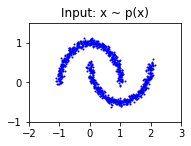

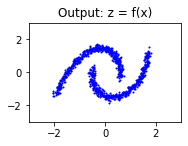

====> Test loss: -0.0155


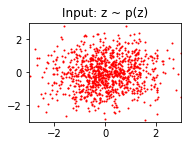

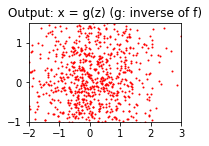

'20.73s'

<Figure size 432x288 with 0 Axes>

In [ ]:
from timeit import default_timer as timer
# run
start = timer()
for epoch in range(1, N_EPOCHS + 1):
    train(epoch, model, optimizer, prior_z, train_loader)
    test(epoch, model, prior_z, test_loader)
    sample(epoch, model, prior_z)
f"{timer() - start:.02f}s"

**Q19: Explain why Normalizing flows do not fit well when there are many clusters in data**

Since the prior is a simple multivariate gaussian, this method cannot handle input too complex distribtuions. In particular, this may cause the Normalizing flows to perform badly on data distributions with many clusters.

**Q20: As a conclusion, how would you compare the advantages and shortcomings of GANs, VAEs and Normalizing flows?**

To conclude, our best fit for the two moons dataset was the GAN model. However, this model required a lot of parameter tuning to find a stable and consistent model since the results are highly impacted by many parameters. The VAE model couldn't fit well enough with our implementation on this dataset. The Normalizing Flow model also works nicely on this dataset (since there are only two clusters) and we can easily get a fitting that gets the shape of the distribution without much parameter tuning and with a simple (not to wide or deep) model.